In [1]:
#importing needed packages
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential, Model 
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
import os
import os.path
from pathlib import Path
import glob
import pandas as pd
import random
!pip install Augmentor
import Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
class_names = ['CASUAL', 'CLASSIC', 'MODERN', 'NATURAL']#name of the classes
nb_classes = len(class_names)
image_size = (120,120)#size of image needed

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Train_Data_Path = Path("/content/drive/MyDrive/TRAIN")#importing train data
Test_Data_Path = Path("/content/drive/MyDrive/TEST")#importing test data

#print(Train_Data_Path.glob(r"**\\*.jpg"))

In [5]:
p_Xtrain = Augmentor.Pipeline(Train_Data_Path)
p_Xtrain.rotate(probability=0.7, max_left_rotation=20, max_right_rotation=20)
p_Xtrain.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
p_Xtrain.sample(1000)

Initialised with 241 image(s) found.
Output directory set to /content/drive/MyDrive/TRAIN/output.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x7F7696022A50>: 100%|██████████| 1000/1000 [00:32<00:00, 30.43 Samples/s]


In [6]:
p_test = Augmentor.Pipeline(Test_Data_Path)
p_test.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p_test.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
p_test.sample(400)

Initialised with 236 image(s) found.
Output directory set to /content/drive/MyDrive/TEST/output.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x7F7695EE5BD0>: 100%|██████████| 400/400 [00:10<00:00, 37.88 Samples/s]


In [7]:
Train_JPG_Path = list(Train_Data_Path.glob("**/*.jpg"))
Test_JPG_Path = list(Test_Data_Path.glob(r"**/*.jpg"))#changing it to list(.jpeg) path

print(len(Train_JPG_Path))
print(len(Test_JPG_Path))



7394
2236


In [8]:
Train_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Train_JPG_Path))
Test_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_JPG_Path))#defining the label values with the help of the folder name

In [9]:
Train_JPG_Path_Series = pd.Series(Train_JPG_Path,name="JPG").astype(str)
Train_JPG_Labels_Series = pd.Series(Train_JPG_Labels,name="CATEGORY").tolist()
Test_JPG_Path_Series = pd.Series(Test_JPG_Path,name="JPG").astype(str)
Test_JPG_Labels_Series = pd.Series(Test_JPG_Labels,name="CATEGORY").tolist()#converting all the values to series


In [10]:
def convertlabels(y):#converting label string to class value
    labels=[]
    for i in range (0,len(y)):
            if y[i]=="CASUAL": labels.append(0)#help of if else loop defining class values
            elif y[i]=="CLASSIC": labels.append(1)
            elif y[i]== "MODERN": labels.append(2)
            else: labels.append(3)
    labels=np.array(labels)#conv of list to array
    return labels
    
def convertimage(path):#converting path to image
    images=[]
    for i in path:
        image = cv2.imread(i)#reading image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#converting BGR image to RGB
        image = cv2.resize(image, image_size)#resizing the input image acc to model input size
        images.append(image)#appending the 2d array
    return np.array(images)

In [11]:
X_train=convertimage(Train_JPG_Path_Series)#converting train path to train image
X_test=convertimage(Test_JPG_Path_Series)#converting test path to test image
Y_train=convertlabels(Train_JPG_Labels_Series)#converting train label string to class value
Y_test=convertlabels(Test_JPG_Labels_Series)#converting test label string to class value


In [12]:
X_train,Y_train=shuffle(X_train,Y_train,random_state=42)
X_test,Y_test=shuffle(X_test,Y_test,random_state=42)#shuffle the train and test values
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')#converting it into float32
X_train /= 255
X_test /= 255#normalizing the values


print("X_train shape", X_train.shape)
print("y_train shape", Y_train.shape)
print("X_test shape", X_test.shape)#printing all the dimensions
print("y_test shape", Y_test.shape)



X_train shape (7394, 120, 120, 3)
y_train shape (7394,)
X_test shape (2236, 120, 120, 3)
y_test shape (2236,)


In [13]:
model = Sequential()#defining a model
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(120,120, 3)))#adding convolutional layer
model.add(MaxPooling2D((2, 2)))#maxpooling the output of the previous layer with 2x2
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))#inorder prevent over fitting we are using drop out boxes
model.add(Conv2D(64, (3, 3), activation='relu'))#repeating the above process 3 times
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))#adding dense layers which helps to get us kernel which deals with seprating classes 
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))#there are 4 classes to be seprated so here input is 4

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        1

In [15]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])#compili

In [16]:
history = model.fit(X_train, Y_train,epochs=20, 
                    validation_data=(X_test, Y_test))#fitting the model with the train data and validating

Epoch 1/20
232/232 [==============================] - 93s 396ms/step - loss: 0.9060 - accuracy: 0.6311 - val_loss: 2.1919 - val_accuracy: 0.1874
Epoch 2/20
232/232 [==============================] - 96s 414ms/step - loss: 0.4235 - accuracy: 0.8393 - val_loss: 4.4991 - val_accuracy: 0.1534
Epoch 3/20
232/232 [==============================] - 94s 405ms/step - loss: 0.2022 - accuracy: 0.9320 - val_loss: 6.2707 - val_accuracy: 0.1310
Epoch 4/20
232/232 [==============================] - 94s 406ms/step - loss: 0.1081 - accuracy: 0.9640 - val_loss: 6.7159 - val_accuracy: 0.1753
Epoch 5/20
232/232 [==============================] - 95s 411ms/step - loss: 0.0741 - accuracy: 0.9777 - val_loss: 7.4088 - val_accuracy: 0.1986
Epoch 6/20
232/232 [==============================] - 94s 407ms/step - loss: 0.0550 - accuracy: 0.9828 - val_loss: 6.5858 - val_accuracy: 0.1726
Epoch 7/20
232/232 [==============================] - 97s 418ms/step - loss: 0.0394 - accuracy: 0.9861 - val_loss: 9.8079 - val_ac

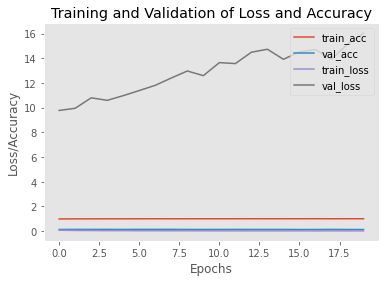

In [ ]:
#Plotting the train accuracy
N = 20 # Number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training and Validation of Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.grid(False)

In [ ]:
# Evaluating the model on test and train data to finding the loss and accuracy
results = model.evaluate(X_test, Y_test)
# Accuracy and loss for test data
print("Loss of the model  while using  test datas ", results[0])
print("Accuracy of the model while using  test datas t", results[1]*100, "%")
results = model.evaluate(X_train, Y_train)
# Accuracy and loss for Train data
print("Loss of the model  while using  train datas  ", results[0])
print("Accuracy of the model while using  train datas ", results[1]*100, "%")

58/58 [==============================] - 6s 105ms/step - loss: 16.0309 - accuracy: 0.1225
Loss of the model  while using  test datas  16.03093910217285
Accuracy of the model while using  test datas t 12.254901975393295 %
200/200 [==============================] - 21s 106ms/step - loss: 1.7162e-04 - accuracy: 1.0000
Loss of the model  while using  train datas   0.0001716162805678323
Accuracy of the model while using  train datas  100.0 %


In [ ]:
predIdxs = model.predict(X_test)#predicting the label values
label = ['CASUAL', 'CLASSIC', 'MODERN', 'NATURAL']

from sklearn.metrics import classification_report
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_test, predIdxs,target_names=label))#printing classification metrics

              precision    recall  f1-score   support

      CASUAL       0.09      0.49      0.15       160
     CLASSIC       0.34      0.03      0.05       774
      MODERN       0.08      0.47      0.13       129
     NATURAL       0.71      0.08      0.14       773

    accuracy                           0.12      1836
   macro avg       0.31      0.27      0.12      1836
weighted avg       0.46      0.12      0.11      1836



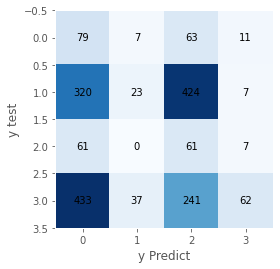

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, predIdxs)
# Plot confusion matrix
plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y test")
plt.grid(False)
plt.show()